In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'legend.fontsize': 15,
         'xtick.major.size': 8,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         }
plt.rcParams.update(params)
plt.style.use('science')

## Frequentist vs Bayesian linear regression
In many fields, we are interested in estimating parameters of interest given some observables (i.e. the measured data). For us, physicists, the parameters of interest are physical quantities informing us about the laws of nature. Often, these laws follow linear trends according to some physical parameters and we're interested in doing linear regression, i.e. given some noisy observed data and a physical model, determining the underlying physical parameters and see if they are agreeing with the physical model. This linear regression can be done in two manners, the frequentist way or the Bayesian way. 

In this notebook, I'll explore two types of linear regression characterized by different visions of statistics. I won't delve really deep in what is implied for each one of this view but to put it simply: 
- __Frequentist view__: probabilities are viewed as the frequency at which an event repeats itself in an experiment
- __Bayesian view__:  probabilites are viewed as a degree of belief/confidence.

In the parameter estimation ocurring during linear regression, frequentists assume a confidence interval (for example 95%) around a **fixed parameter of interest** and use statistical tests to do hypothesis testing (i.e. check if the observed data is consistent with a null hypothesis). The problem is that there's no clear way on how to define this confidence interval and you might be sometimes in situations where, even though the null hypothesis is correct, you reject it due to a poor choice of confidence interval.  

The Bayesian view is more elegant (in my opinion). Instead of assuming a fixed parameter of interest, the **parameter of interest becomes a random variable** following a **posterior distribution**. I'll go into more details when the time comes but this approach is powerful since it allows you to bypass the problems ocurring when you need to choose p-values or confidence intervals. Instead, the information loss due to noise is naturally included in the framework and more complex cases (like multimodality for example) can be encoded. 

Enough babbling about frequentist vs Bayesian. Let's get started with linear regression. Linear regression is the problem of finding the optimal regression coefficients $\beta$ given observed data $\mathbf{y}$ such that
$$
\mathbf{y}^\star = \beta \mathbf{x} \qquad \mathbf{y} = \beta \mathbf{x} + \boldsymbol{\epsilon}
$$
where $\boldsymbol{\epsilon} \sim  \mathcal{N}(0, \Sigma)$ is noise (estimated during the experiment in our case).


### A simple toy problem
Let's imagine we're back in year 1 and doing our first class of Classical Mechanics. One of the first derivation that we can make is simply the linear relationship between position $x(t)$ and at constant speed $v(t)=v_0$ when there is no acceleration (no force on the system). This means we can write
$$
x(t) = x_{0} + \int_{0}^{t} \frac{dx}{dt'} dt'\rightarrow x(t)= x_{0} + v_0 t
$$

Great. Now, let's assume that we have a bowling ball that we launch at speed $v_{0}$ from a point $x_0$ and that we ignore any kind of friction, and that the bowling ball rolls without slipping. We can use our favorite tool to measure the speed of the ball, let's say a speedometer 3000 and get measurements of the ball with uncorrelated Gaussian errors. The observed data will follow the trend 
$$
\begin{align}
y_t &= x_{0} + v_{0}t + \epsilon
\end{align}
$$

Let's simulate these measurements below. I'll use astropy.units to show some cool things that we can do to not have problems with units :).

In [8]:
# Defining initial parameters
x0 = 10 * u.meter
v0 = 20 * u.meter / u.s

print("Initial position: ", x0)
print("Initial speed: ", v0)

Initial position:  10.0 m
Initial speed:  20.0 m / s


Now, we want to plot the measurements $y= x_0 + v_0 t + \epsilon$

In [14]:
def forward_model(t, x0 = 10, v0 = 20): 
    return x0 + v0 * t

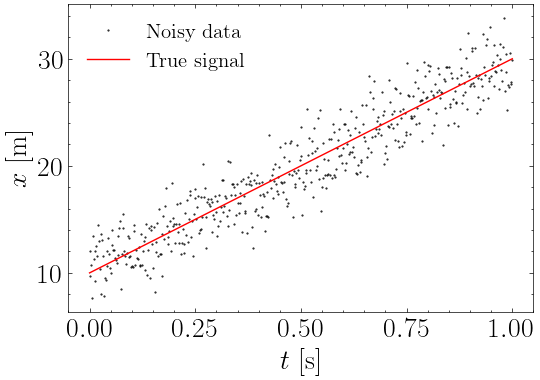

In [21]:
num_points = 500 # Number of measured data points
t = np.linspace(0, 1, num_points) * u.second
sigma = 2 # standard deviation (in meters) 
epsilon = np.random.normal(loc = 0, scale = sigma, size = (num_points,)) * u.meter
y = forward_model(t = t, x0 = x0, v0 = v0) + epsilon

fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "k")
ax.plot(t, forward_model(t, x0, v0), label = "True signal", color = "r")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$x$ [m]")
plt.legend()

Great, we have our noisy data and we now want to do our linear regression. Let's start with the frequentist linear regression

## Frequentist linear regression
In the frequentist linear regression, we can rewrite the measurement equation in matrix form: 
$$
\begin{align}
\\
y_t &= \beta_{0} + \beta_{1}t + \epsilon
\\
\mathbf{y} &= \begin{pmatrix}
\beta_0 + \beta_1 t_1 \\
\beta_0 + \beta_1 t_2 \\
\vdots \\
\beta_0 + \beta_1 t_m \\
\end{pmatrix}
\\
 &= \begin{pmatrix}
1 & t_1 \\
1 & t_2 \\
\vdots & \vdots \\
1 & t_m 
\end{pmatrix}
\begin{pmatrix}
\beta_{0} \\ \beta_{1} 
\end{pmatrix}
\end{align}
\\
= \mathbf{t} \beta + \boldsymbol{\epsilon}
$$
where $\mathbf{y} \in \mathbb{R}^{m}$ represents our collection of measurements, $m$ is the total number of measurements, $\mathbf{t}$ is our input variable (assumed to be perfectly known in a simple frequentist linear regression setting).   

In the frequentist linear regression, the optimal regression coefficients $\beta^\star$ are obtained by applying the formula (where here we map $\mathbf{t}\rightarrow \mathbf{x}$)
$$
\beta^{\star}=(\mathbf{x}^{T} \mathbf{x}+ \lambda)^{-1}\mathbf{x}^{T} \mathbf{y}
$$
We can also compute the covariance matrix on the optimal parameters $\beta^\star$ when the noise is Gaussian. We have 
$$
\text{Cov}(\beta^\star)=\sigma^2(\mathbf{x}^{T}\mathbf{x}+ \lambda)^{-1}
$$
where $\lambda$ is a Ridge regularization to make sure that the matrix is invertible. 

Let's set $\lambda=10^{-5}$ to start. 


In [112]:
# Computing optimal regression coefficients
X = np.column_stack([np.ones_like(t), t])
A = X.T @ X
ridge_reg = 0 * X.unit ** 2
inv_mat = np.linalg.inv(A + ridge_reg)
beta_star = (inv_mat @ X.T @ y).value

# Computing covariance 
cov = (sigma * u.meter) ** 2 * inv_mat
stds = np.sqrt(np.diag(cov))

beta_gt = np.array([x0.value.item(), v0.value.item()])
print("Ground-truth", *beta_gt)
print("Optimal regression parameters", beta_star)
print("Standard deviation ", stds.to_string())

Ground-truth 10.0 20.0
Optimal regression parameters [10.14729864 19.64805825]
Standard deviation  [0.17861744 0.30921961] m / s


In [108]:
x0.value

np.float64(10.0)

In [103]:
x0

<Quantity 10. m>

That's pretty good ! Our uncertainties are good and are really constraining what's going on here. Let's plot the fitted model vs the ground-truth model. 

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

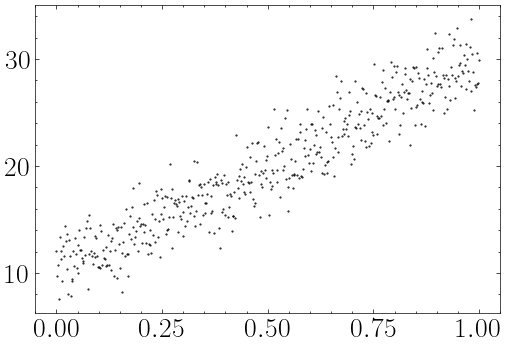

In [113]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.plot(t, y, ".", markersize = 1, label = "Noisy data", color = "k")
ax.plot(t, forward_model(t, *beta_gt), label = "True signal", color = "r")
ax.plot(t, forward_model(t, *beta_star), label = "Fitted signal", color = "g")
ax.set(xlabel = r"$t$ [s]", ylabel = r"$x$ [m]")
plt.legend()

In [96]:
np.sqrt(np.diag(cov))

<Quantity [0.17861744, 0.30921961] m / s>

In [97]:
cov

<Quantity [[ 0.03190419, -0.04780838],
           [-0.04780838,  0.09561677]] m2 / s2>

In [94]:
A

<Quantity [[500.        , 250.        ],
           [250.        , 166.83366733]] s2>

In [ ]:
sigam

In [73]:
A

<Quantity [[500.        , 250.        ],
           [250.        , 166.83366733]] s2>

In [37]:
X.shape

(500, 2)